In [1]:
!pip3 install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
!pip install qiskit==1.3
!pip install qiskit-aer==0.15
!pip install pylatexenc==2.10
!pip install qiskit_ibm_runtime==0.34.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [qiskit]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 88.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'pylatexenc' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pylatexenc'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=b051061fae8da183bbe65eab177c59b3d

In [3]:
!pip install requests==2.32.4

In [4]:
import qiskit
qiskit.__version__

'1.3.0'

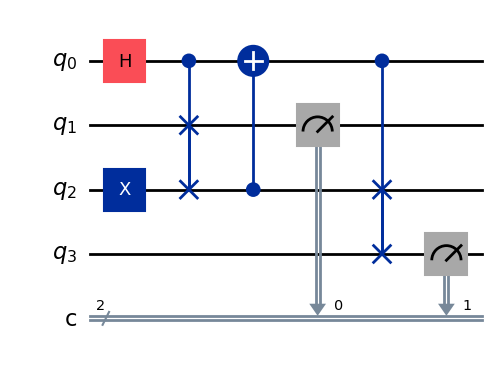

In [5]:
# 1-level QGB

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

q, c = QuantumRegister(4, "q"), ClassicalRegister(2, "c")

qc = QuantumCircuit(q, c)
qreg = qc.qregs[0]
creg = qc.cregs[0]

qc.x(qreg[2])
qc.h(qreg[0])
qc.cswap(qreg[0], qreg[1], qreg[2])
qc.cx(qreg[2], qreg[0])
qc.cswap(qreg[0], qreg[2], qreg[3])

for i in range(2):
  qc.measure(qreg[2 * i + 1], creg[i])

# qc = QuantumCircuit(4, 2)
# # ball: 2, control: 0, path_1: 1, path_2: 3
# qc.x(2)
# qc.h(0)
# qc.cswap(0, 1, 2)
# qc.cx(2, 0)
# qc.cswap(0, 2, 3)

# for i in range(2):
#   qc.measure(2 * i + 1, i)


qc.draw(output="mpl")



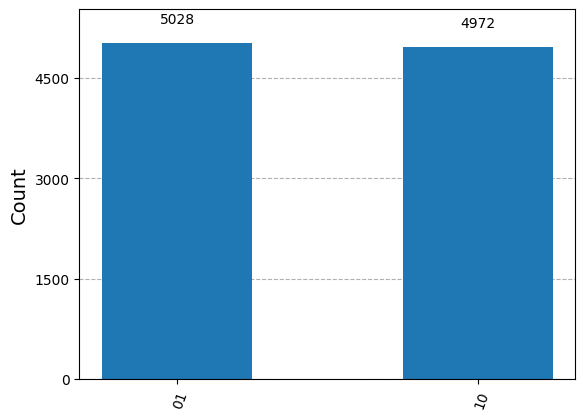

In [6]:
from qiskit_aer.primitives import SamplerV2
from qiskit.visualization import plot_histogram, plot_bloch_multivector

sampler = SamplerV2()
job = sampler.run([qc], shots=10000)
result = job.result()
counts = result[0].data.c.get_counts()
plot_histogram(counts)

# 2 - level QGB

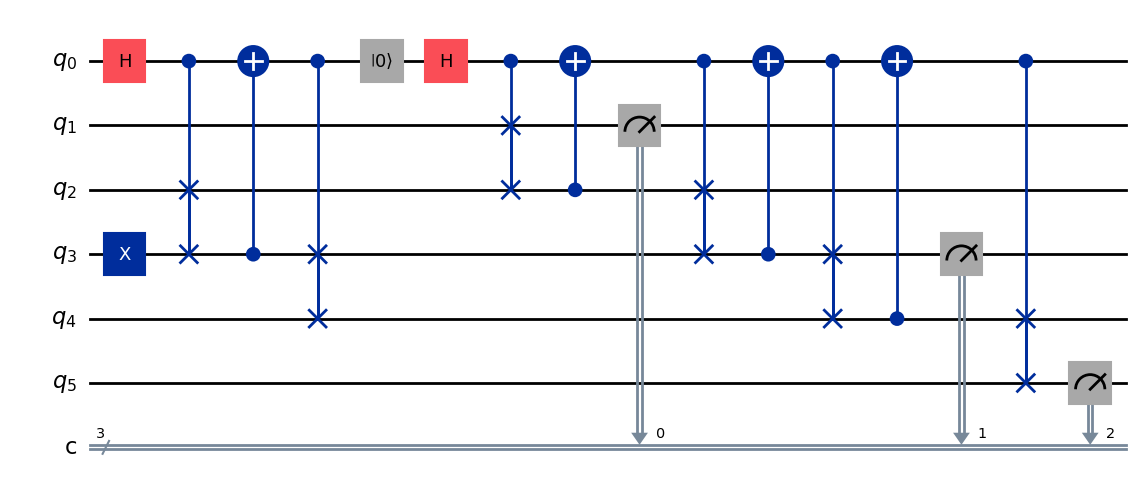

In [7]:
# Use qregs instead of ints this time?
def qpeg(qc: QuantumCircuit, ball: int, path_1: int, path_2: int, control: int):
  qc.cswap(control, path_1, ball)
  qc.cx(ball, control)
  qc.cswap(control, ball, path_2)

# qc = QuantumCircuit(4, 2)
# # # ball: 2, control: 0, path_1: 1, path_2: 3
# # qc.x(2)
# # qc.h(0)
# # qc.cswap(0, 1, 2)
# # qc.cx(2, 0)
# # qc.cswap(0, 2, 3)
# qpeg(qc, 2, 1, 3, 0)
# for i in range(2):
#   qc.measure(2 * i + 1, i)

# qc.draw(output="mpl")
qc2 = QuantumCircuit(6, 3)
qc2.x(3)
qc2.h(0)
qpeg(qc2, 3, 2, 4, 0)
qc2.reset(0)
qc2.h(0)
qpeg(qc2, 2, 1, 3, 0)
qc2.cx(3, 0)
qpeg(qc2, 4, 3, 5, 0)

for q in range(3):
  qc2.measure(2 * q + 1, q)


qc2.draw(output="mpl")


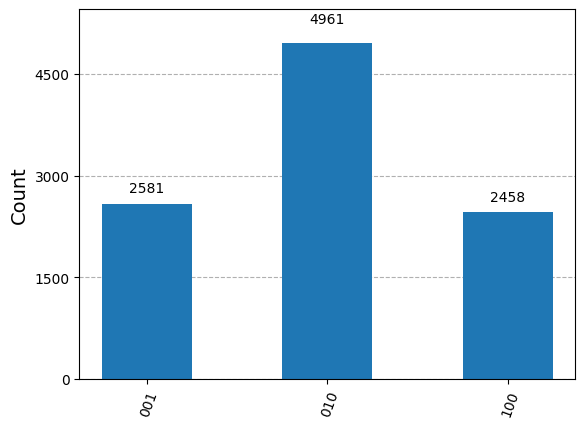

In [8]:
sampler = SamplerV2()
job = sampler.run([qc2], shots=10000)
result = job.result()
counts = result[0].data.c.get_counts()
plot_histogram(counts)

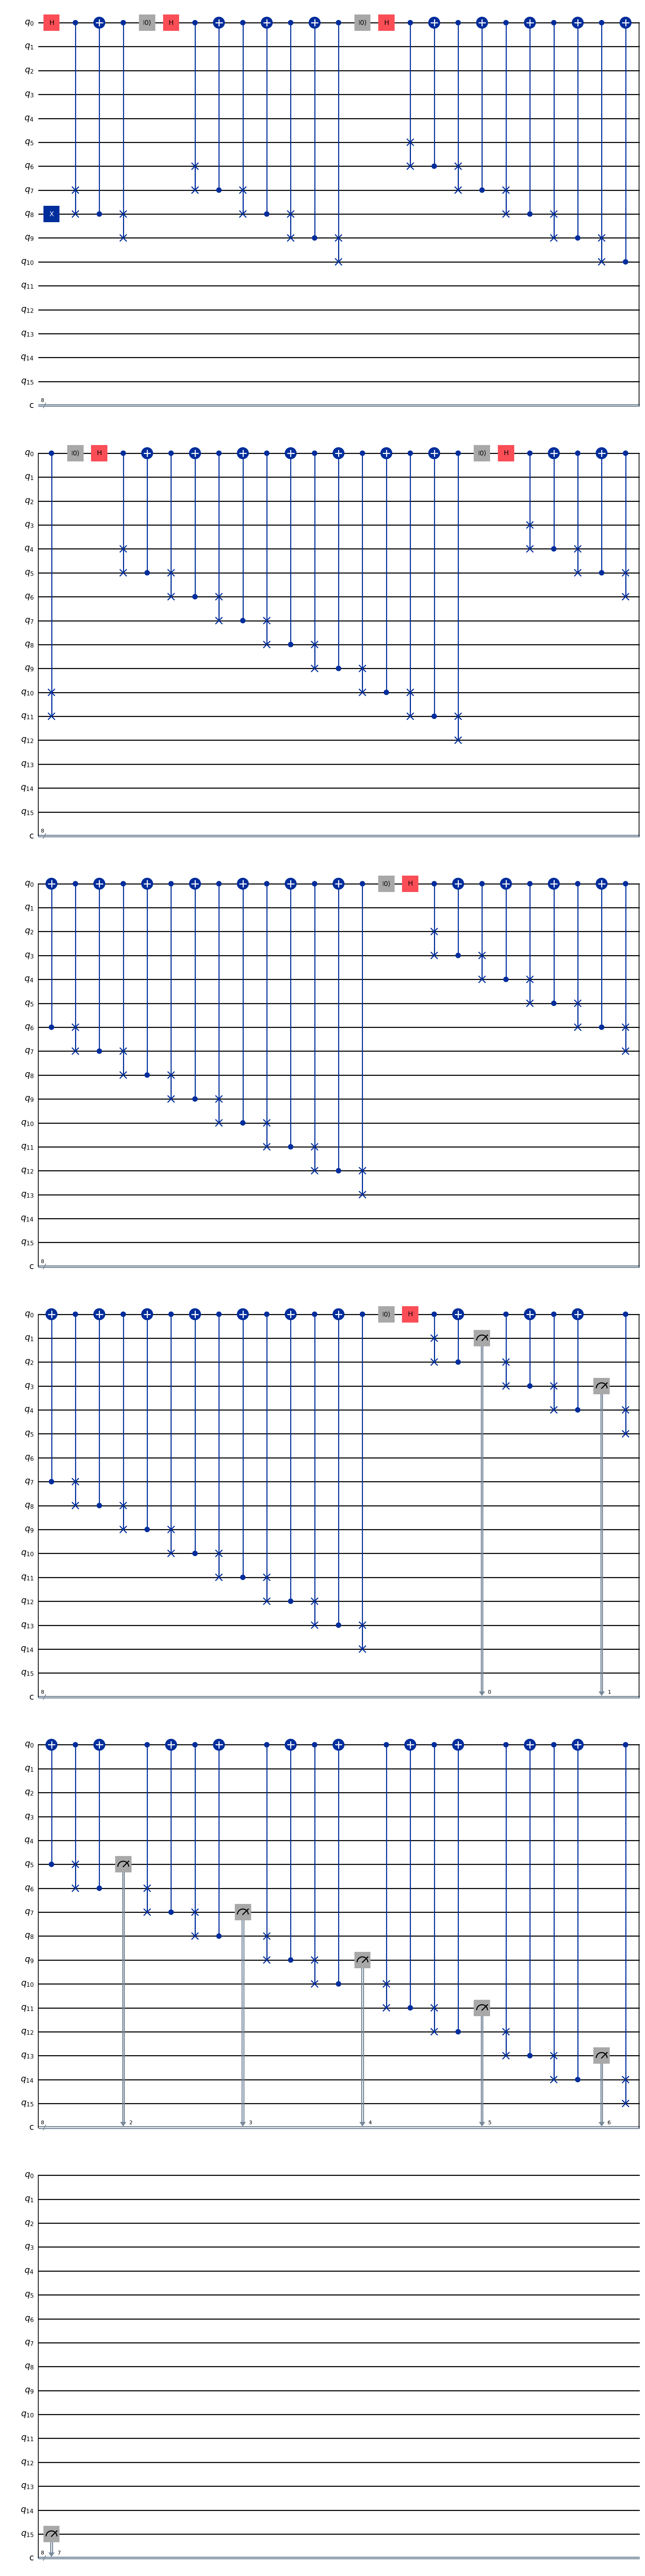

In [30]:
# n-level QGB

def nth_level_QGB(n: int, qc: QuantumCircuit) -> None:
  # Placing the 'ball'
  qc.x(n + 1)

  # 1st level
  qc.h(0)
  qpeg(qc, n + 1, n, n + 2, 0)

  # k-th level (2 <= k <= n)
  for level in range(2, n + 1):
    qc.reset(0)
    qc.h(0)
    for i in range(1, level + 1):
      start = n + 1 + 2 * i - (level + 1)
      qpeg(qc, start, start - 1, start + 1, 0)
      if i < level:
        qc.cx(start + 1, 0)

n = 7

q, c = QuantumRegister(2 * n + 2, "q"), ClassicalRegister(n + 1, "c")

qc3 = QuantumCircuit(q, c)

nth_level_QGB(n, qc3)

# Measurement
for i in range(n + 1):
  qc3.measure(2 * i + 1, i)


qc3.draw(output="mpl")

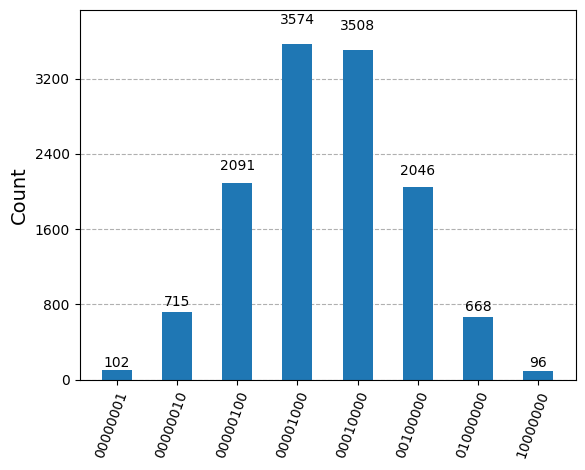

In [31]:
num_shots = (2 ** n) * 100

sampler = SamplerV2()
job = sampler.run([qc3], shots=num_shots)
result = job.result()
counts = result[0].data.c.get_counts()
plot_histogram(counts)

In [11]:
import numpy as np

#Exponential QGB

In [20]:
def exponential_QGB(n: int, qc: QuantumCircuit, bias_factor: float = 0.7) -> None:
    # Placing the 'ball'
    qc.x(n + 1)

    # 1st level - use biased rotation instead of Hadamard
    theta1 = 2 * np.arccos(np.sqrt(bias_factor))
    qc.ry(theta1, 0)
    qpeg(qc, n + 1, n, n + 2, 0)

    # k-th level (2 <= k <= n) - each level gets more biased
    for level in range(2, n + 1):
        qc.reset(0)
        # Make each level more exponential
        current_bias = bias_factor ** level
        theta = 2 * np.arccos(np.sqrt(current_bias))
        qc.ry(theta, 0)

        for i in range(1, level + 1):
            start = n + 1 + 2 * i - (level + 1)
            qpeg(qc, start, start - 1, start + 1, 0)
            if i < level:
                qc.cx(start + 1, 0)

# Test exponential QGB
n = 7
q, c = QuantumRegister(2 * n + 2, "q"), ClassicalRegister(n + 1, "c")
qc_exp = QuantumCircuit(q, c)

exponential_QGB(n, qc_exp, bias_factor=0.5)


7-Level Exponential QGB 
Exponential QGB results:
{'00000010': 473, '00000001': 282, '00000100': 204, '00001000': 38, '00010000': 2, '00100000': 1}


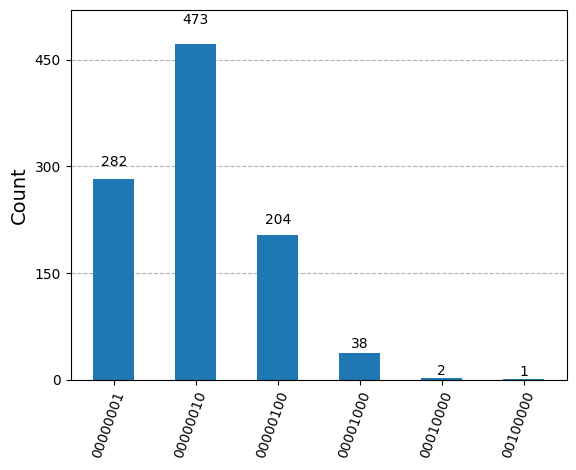

In [21]:
# Measurement
for i in range(n + 1):
    qc_exp.measure(2 * i + 1, i)

print(f"{n}-Level Exponential QGB ")
qc_exp.draw(output="mpl")

job = sampler.run([qc_exp], shots=1000)
result = job.result()
counts_exp = result[0].data.c.get_counts()
print("Exponential QGB results:")
print(counts_exp)
plot_histogram(counts_exp)

# Hadamrd QW-> N level

In [25]:
def quantum_walk_QGB(n: int, qc: QuantumCircuit) -> None:
    # Placing the 'ball'
    qc.x(n + 1)

    # 1st level - add phase for quantum walk behavior
    qc.h(0)
    qc.p(np.pi/8, 0)  # phase for interference
    qpeg(qc, n + 1, n, n + 2, 0)

    # k-th level (2 <= k <= n)
    for level in range(2, n + 1):
        qc.reset(0)
        qc.h(0)
        # Different phase for each level to create walk interference
        qc.p(np.pi * level / 8, 0)

        for i in range(1, level + 1):
            start = n + 1 + 2 * i - (level + 1)

            # Modified qpeg with phases for quantum walk
            qc.cswap(0, start - 1, start)
            qc.p(np.pi/16, start)  # phase on the ball position
            qc.cx(start, 0)
            qc.cswap(0, start, start + 1)

            if i < level:
                qc.cx(start + 1, 0)

# Test quantum walk QGB
n = 5
q, c = QuantumRegister(2 * n + 2, "q"), ClassicalRegister(n + 1, "c")
qc_walk = QuantumCircuit(q, c)

quantum_walk_QGB(n, qc_walk)

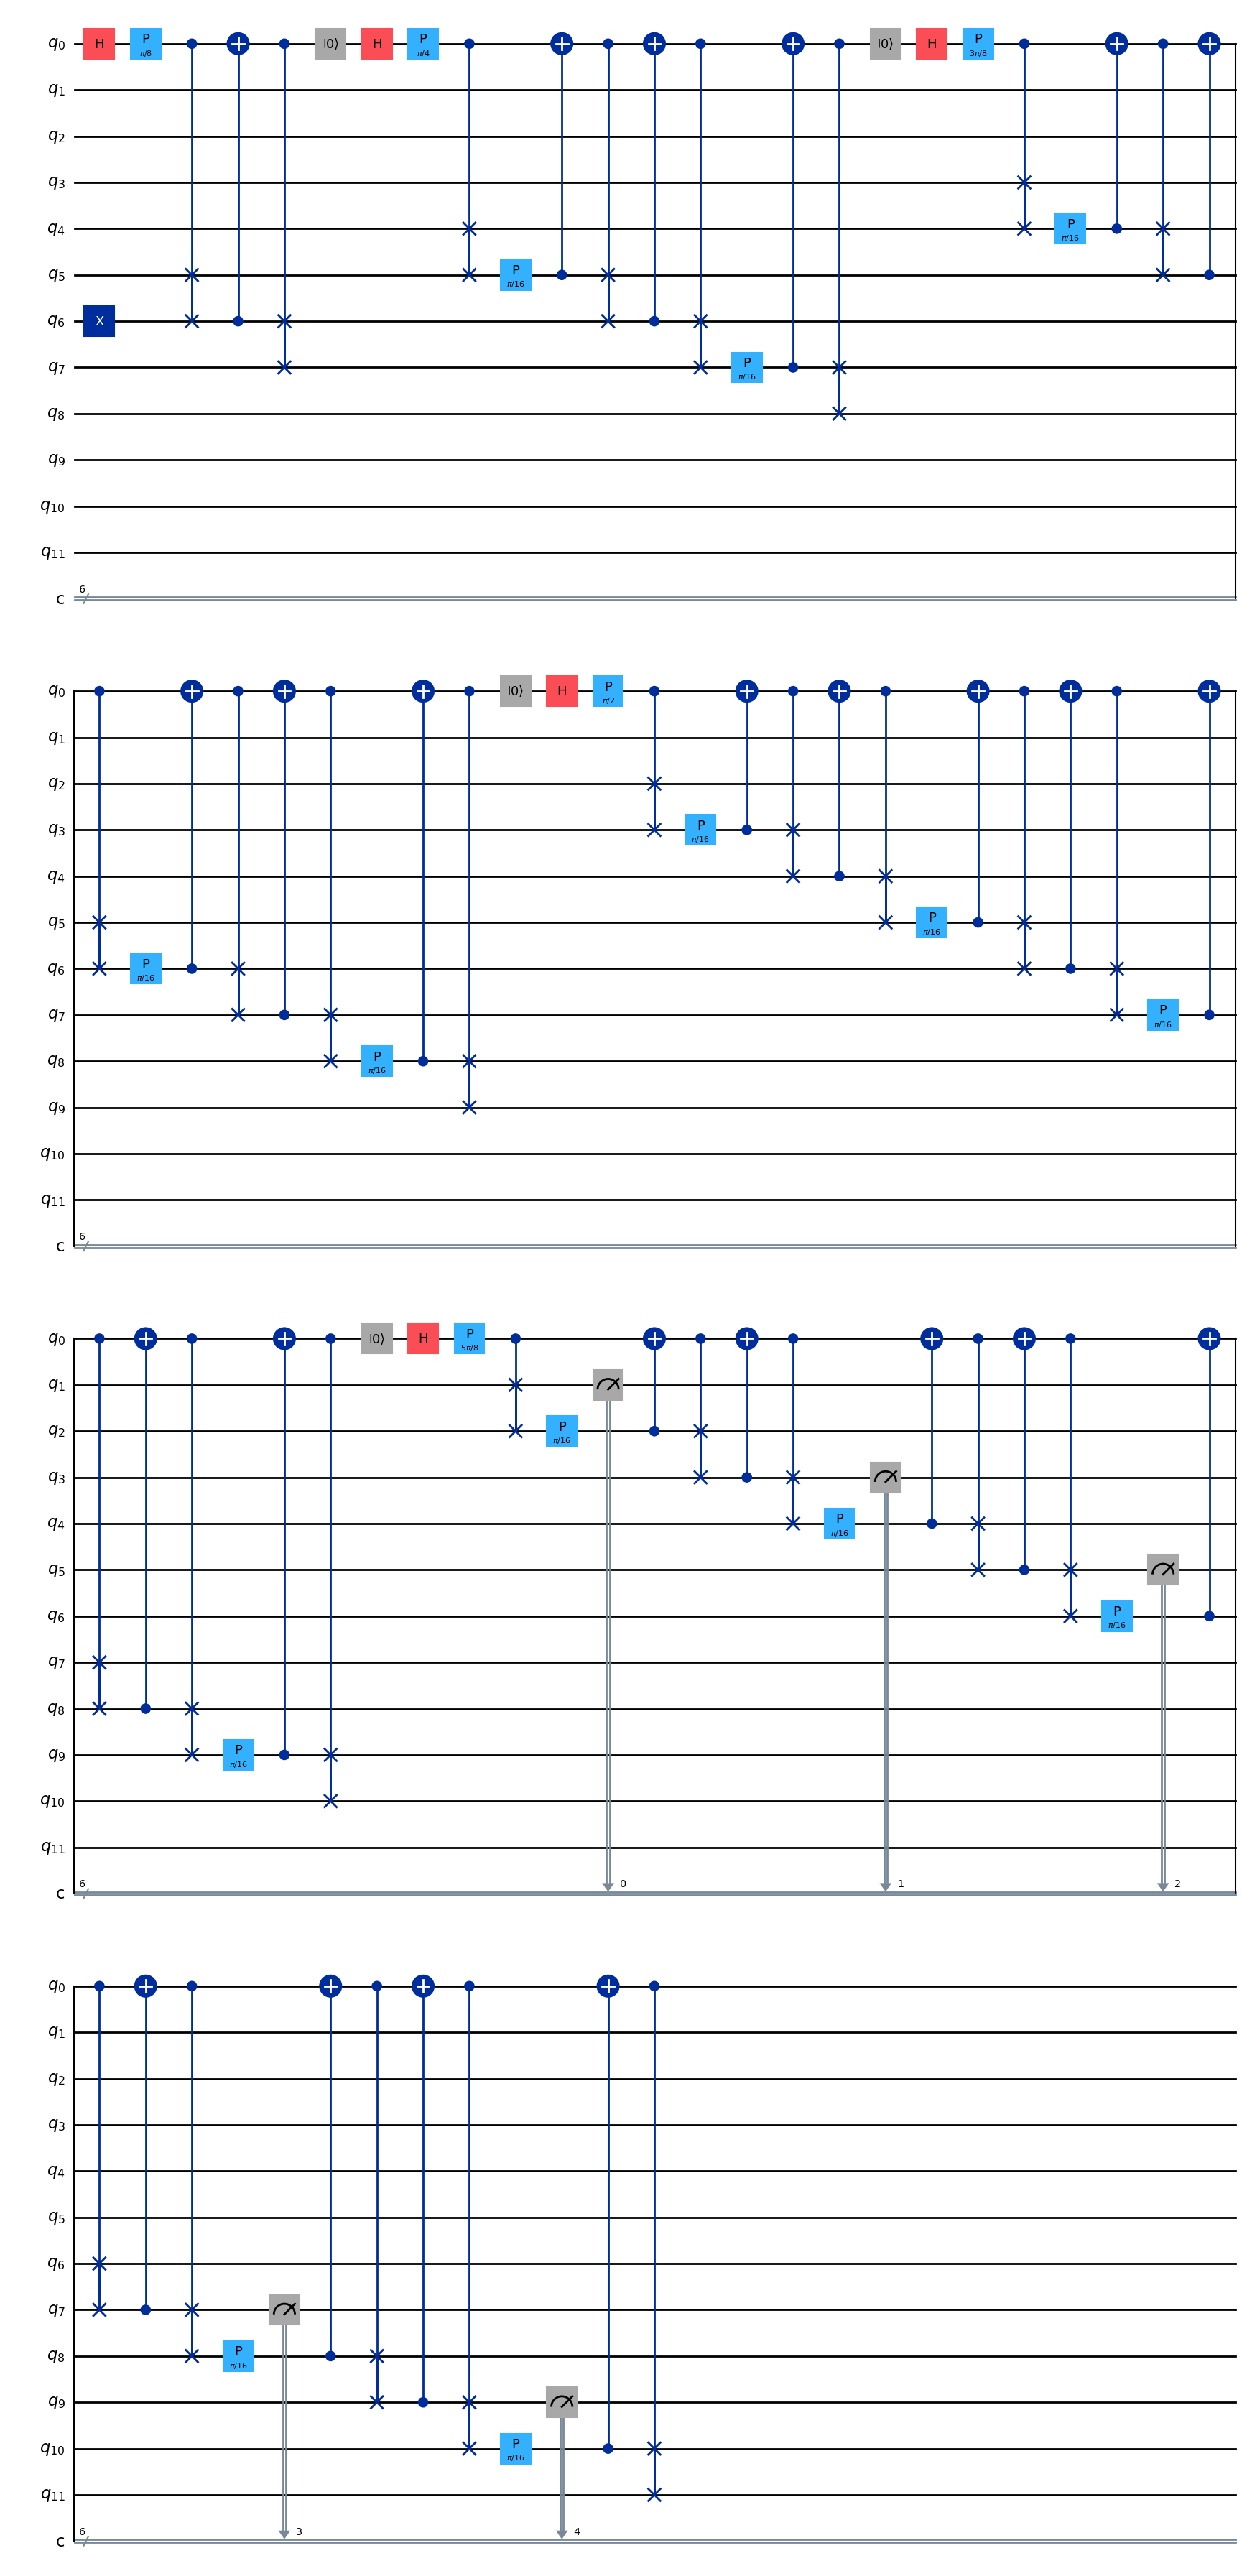

In [26]:
for q in range(n):
    qc_walk.measure(2 * q + 1, q)

qc_walk.draw(output="mpl")


 5-Level Quantum Walk QGB 
Quantum Walk QGB results:
{'000100': 3178, '010000': 1572, '100000': 316, '000010': 1515, '001000': 3088, '000001': 331}


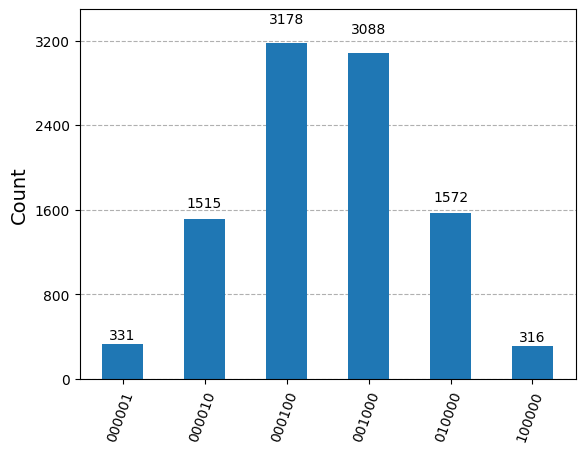

In [27]:
# Measurement
for i in range(n + 1):
    qc_walk.measure(2 * i + 1, i)

print(f"\n {n}-Level Quantum Walk QGB ")
qc_walk.draw(output="mpl")

job = sampler.run([qc_walk], shots=10000)
result = job.result()
counts_walk = result[0].data.c.get_counts()
print("Quantum Walk QGB results:")
print(counts_walk)
plot_histogram(counts_walk)

#Compare the 3 (Original, Exponential, Quantum Walk)

Original: Uses qc.h(0) at every level - uniform distribution

Exponential: Uses qc.ry(theta, 0) with bias_factor^level - exponential decay

Quantum Walk: Uses qc.h(0) + qc.p(phase, 0) and phases in qpeg - interference effects


 Comparison of all three 5-level variants

Original QGB results:
{'000100': 3139, '000010': 1567, '001000': 3126, '010000': 1545, '000001': 311, '100000': 312}
Position distribution: {1: 311, 2: 1567, 4: 3139, 8: 3126, 16: 1545, 32: 312}

Exponential QGB results:
{'000100': 942, '000001': 4550, '000010': 4437, '001000': 70, '010000': 1}
Position distribution: {1: 4550, 2: 4437, 4: 942, 8: 70, 16: 1}

Quantum Walk QGB results:
{'000100': 3179, '000010': 1535, '010000': 1565, '000001': 288, '001000': 3120, '100000': 313}
Position distribution: {1: 288, 2: 1535, 4: 3179, 8: 3120, 16: 1565, 32: 313}


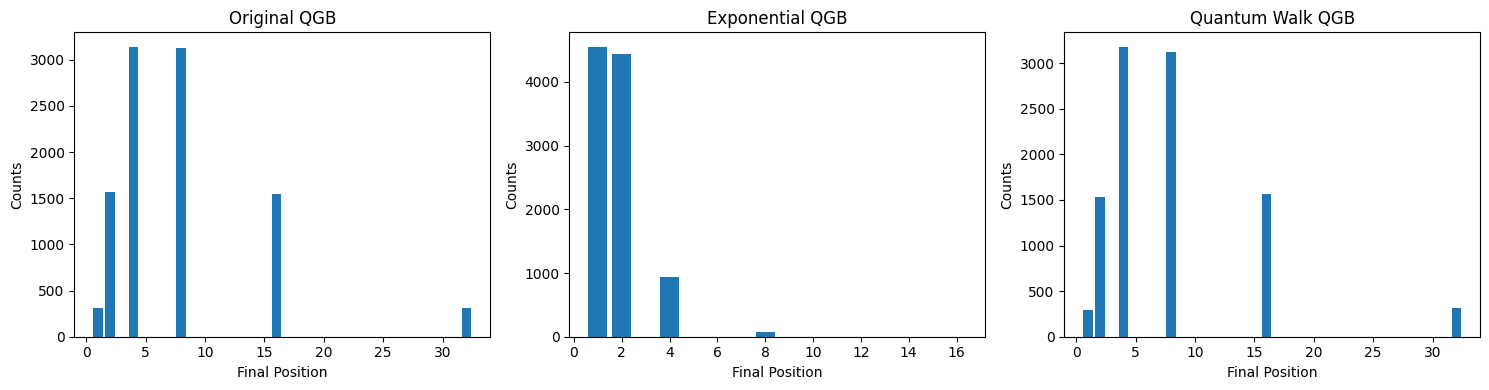

In [29]:
n = 5
circuits = []
names = ["Original", "Exponential", "Quantum Walk"]

for name in names:
    q, c = QuantumRegister(2 * n + 2, "q"), ClassicalRegister(n + 1, "c")
    qc = QuantumCircuit(q, c)

    if name == "Original":
        nth_level_QGB(n, qc)
    elif name == "Exponential":
        exponential_QGB(n, qc, bias_factor=0.4)
    else:  # Quantum Walk
        quantum_walk_QGB(n, qc)

    # Measurement
    for i in range(n + 1):
        qc.measure(2 * i + 1, i)

    circuits.append(qc)

print(f"\n Comparison of all three {n}-level variants")

job = sampler.run(circuits, shots=10000)
result = job.result()

for i, name in enumerate(names):
    counts = result[i].data.c.get_counts()
    print(f"\n{name} QGB results:")
    print(counts)
    # Convert to position-based counting for easier comparison
    positions = {}
    for key, count in counts.items():
        pos = int(key, 2)  # convert binary string to integer
        positions[pos] = count
    print(f"Position distribution: {dict(sorted(positions.items()))}")

# Plot all three
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, name in enumerate(names):
    counts = result[i].data.c.get_counts()
    positions = {}
    for key, count in counts.items():
        pos = int(key, 2)
        positions[pos] = count

    axes[i].bar(positions.keys(), positions.values())
    axes[i].set_title(f'{name} QGB')
    axes[i].set_xlabel('Final Position')
    axes[i].set_ylabel('Counts')

plt.tight_layout()
plt.show()
